In [1]:
#install brian2 and import
!pip install brian2
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.5 MB/s eta 0:00:00


##RUN AT NORMAL TEMPERATURE

WARNING    <ipython-input-14-22e83cdb8524>:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()
 [py.warnings]
  ax[0].legend()



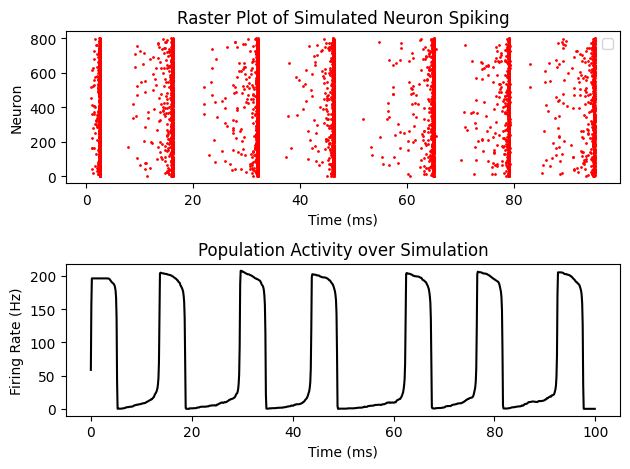

In [14]:
start_scope()

#set duration and cell count. Ratios for excitatory to inhibitory follow the frontal lobe ratio of 4:1
duration = 0.1 * second
N = 1000
Ne = int(0.8 * N)
Ni = N - Ne

# T1 is our reference temperature (body temp), T2 is the simulated temperature that we are applying
T1 = 37
T2 = 37 #Simulates body being at same temperature, this is changed later

#Standard Q10 coefficents. Q10 for tau is to scale tau in response to temperature changes, indicative of time constant changes
#Q10 for syn is to scale syn in response to temp changes, indicative of synaptic kinetics changing in response to temp
tQ10 = 2.5
sQ10 = 2.0

# Temperature scaling factors
tau_scaling = tQ10 ** ((T2 - T1) / 10)
syn_scaling = sQ10 ** ((T2 - T1) / 10)

# tau constant for LiF model
tau = 10 * ms / (tQ10 ** ((T2 - T1) / 10))  # scaled by temp via Q10 manipulation

#voltage behavior that determines how LiF model spikes and resets itself
v_rest = -65 * mV
v_reset = -65 * mV
v_thresh = -50 * mV

#refractory period is dependent on temperature
refractory_period = 2 * ms / (tQ10 ** ((T2 - T1) / 10))

w_exc = 0.8 *  mV * (sQ10 ** ((T2 - T1) / 10))
w_inh = -0.4 * mV * (sQ10 ** ((T2 - T1) / 10))

# LiF Equation
# v-rest - v / tau is basic equation for LiF model
# sigma * xi * (1.0/sqrt(ms)) is an input for synaptic noise
# sigma is amplitude of noise
# xi is a bell curve distribution operater with mean 0 and stdev 1
eqs = '''
dv/dt = (v_rest - v) / tau + sigma * xi * (1.0 / sqrt(ms)): volt (unless refractory)
'''

#amplitude of noise
sigma = 3 * mV

#bunch excitatory neurons and inhibtiroy neurons
Exc_Neurons = NeuronGroup(Ne, eqs, threshold='v > v_thresh', reset='v = v_reset', refractory=refractory_period, method='euler')
Inh_Neurons = NeuronGroup(Ni, eqs, threshold='v > v_thresh', reset='v = v_reset', refractory=refractory_period, method='euler')

#set resting potential of neurons
Exc_Neurons.v = 'v_rest + rand() * 10 * mV'
Inh_Neurons.v = 'v_rest + rand() * 10 * mV'

#form synapses
S_ee = Synapses(Exc_Neurons, Exc_Neurons, on_pre='v_post += w_exc')
S_ei = Synapses(Exc_Neurons, Inh_Neurons, on_pre='v_post += w_exc')
S_ie = Synapses(Inh_Neurons, Exc_Neurons, on_pre='v_post += w_inh')
S_ii = Synapses(Inh_Neurons, Inh_Neurons, on_pre='v_post += w_inh')

#allow synaptic connections to be subject to probability of connetion
S_ee.connect(p=0.1)
S_ei.connect(p=0.1)
S_ie.connect(p=0.1)
S_ii.connect(p=0.1)

#set up monitors to make a not of when LiF neurons fire and reset (we only care about excitatory neurons here)
spike_monitor = SpikeMonitor(Exc_Neurons)

#population monitor to determine firing rate as a whole
pop_monitor = PopulationRateMonitor(Exc_Neurons)

#NORMAL RUN
run(duration)

# Plotting the results
# Use Raster Plot to Visualize Spiking during Simulation
fig, ax = plt.subplots(2)
ax[0].plot(spike_monitor.t/ms, spike_monitor.i, 'r.', markersize=2)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Neuron')
ax[0].set_title('Raster Plot of Simulated Neuron Spiking')
ax[0].legend()
# Look for firing rate across entire population and plot
ax[1].plot(pop_monitor.t/ms, pop_monitor.smooth_rate(window='flat', width=5*ms)/Hz, color='k')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Firing Rate (Hz)')
ax[1].set_title('Population Activity over Simulation')
fig.tight_layout()
fig.show()

##RUN NORMAL TEMPERATURE, THEN APPLY HEATING

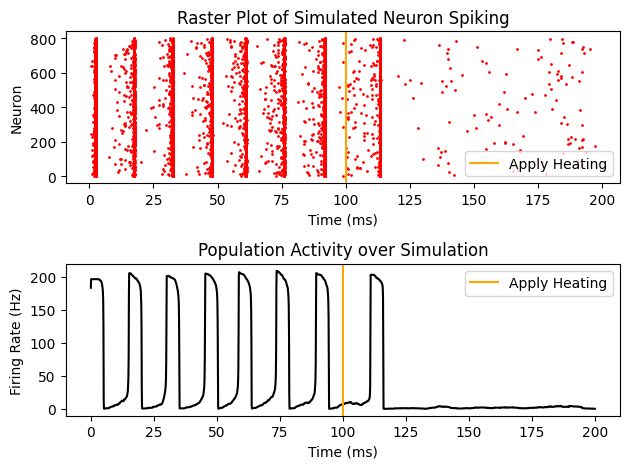

In [21]:
start_scope()

#set duration and cell count. Ratios for excitatory to inhibitory follow the frontal lobe ratio of 4:1
duration = 0.1 * second
N = 1000
Ne = int(0.8 * N)
Ni = N - Ne

# T1 is our reference temperature (body temp), T2 is the simulated temperature that we are applying
T1 = 37
T2 = 37  #Simulates body being at same temperature, this is changed later

#Standard Q10 coefficents. Q10 for tau is to scale tau in response to temperature changes, indicative of time constant changes
#Q10 for syn is to scale syn in response to temp changes, indicative of synaptic kinetics changing in response to temp
tQ10 = 2.5
sQ10 = 2.0

# tau constant for LiF model
tau = 10 * ms / (tQ10 ** ((T2 - T1) / 10))  # scaled by temp via Q10 manipulation

#voltage behavior that determines how LiF model spikes and resets itself
v_rest = -65 * mV
v_reset = -65 * mV
v_thresh = -50 * mV

#refractory period is dependent on temperature
refractory_period = 2 * ms / (tQ10 ** ((T2 - T1) / 10))

w_exc = 0.8 *  mV * (sQ10 ** ((T2 - T1) / 10))
w_inh = -0.4 * mV * (sQ10 ** ((T2 - T1) / 10))

# LiF Equation
# v-rest - v / tau is basic equation for LiF model
# sigma * xi * (1.0/sqrt(ms)) is an input for synaptic noise
# sigma is amplitude of noise
# xi is a bell curve distribution operater with mean 0 and stdev 1
eqs = '''
dv/dt = (v_rest - v) / tau + sigma * xi * (1.0 / sqrt(ms)): volt (unless refractory)
'''

#amplitude of noise
sigma = 3 * mV

#bunch excitatory neurons and inhibtiroy neurons
Exc_Neurons = NeuronGroup(Ne, eqs, threshold='v > v_thresh', reset='v = v_reset', refractory=refractory_period, method='euler')
Inh_Neurons = NeuronGroup(Ni, eqs, threshold='v > v_thresh', reset='v = v_reset', refractory=refractory_period, method='euler')

#set resting potential of neurons
Exc_Neurons.v = 'v_rest + rand() * 10 * mV'
Inh_Neurons.v = 'v_rest + rand() * 10 * mV'

#form synapses
S_ee = Synapses(Exc_Neurons, Exc_Neurons, on_pre='v_post += w_exc')
S_ei = Synapses(Exc_Neurons, Inh_Neurons, on_pre='v_post += w_exc')
S_ie = Synapses(Inh_Neurons, Exc_Neurons, on_pre='v_post += w_inh')
S_ii = Synapses(Inh_Neurons, Inh_Neurons, on_pre='v_post += w_inh')

#allow synaptic connections to be subject to probability of connetion
S_ee.connect(p=0.1)
S_ei.connect(p=0.1)
S_ie.connect(p=0.1)
S_ii.connect(p=0.1)

#set up monitors to make a not of when LiF neurons fire and reset (we only care about excitatory neurons here)
spike_monitor = SpikeMonitor(Exc_Neurons)

#population monitor to determine firing rate as a whole
pop_monitor = PopulationRateMonitor(Exc_Neurons)

#NORMAL RUN
run(duration)
#HOT RUN
# T1 is our reference temperature (body temp), T2 is the simulated temperature that we are applying
T1 = 37
T2 = 45  #Simulates body being at same temperature, this is changed later

#Standard Q10 coefficents. Q10 for tau is to scale tau in response to temperature changes, indicative of time constant changes
#Q10 for syn is to scale syn in response to temp changes, indicative of synaptic kinetics changing in response to temp
tQ10 = 2.5
sQ10 = 2.0

# tau constant for LiF model
tau = 10 * ms / (tQ10 ** ((T2 - T1) / 10))  # scaled by temp via Q10 manipulation

#voltage behavior that determines how LiF model spikes and resets itself
v_rest = -65 * mV
v_reset = -65 * mV
v_thresh = -50 * mV

#refractory period is dependent on temperature
refractory_period = 2 * ms / (tQ10 ** ((T2 - T1) / 10))

w_exc = 0.8 *  mV * (sQ10 ** ((T2 - T1) / 10))
w_inh = -0.4 * mV * (sQ10 ** ((T2 - T1) / 10))
run(duration)

# Plotting the results
# Use Raster Plot to Visualize Spiking during Simulation
fig, ax = plt.subplots(2)
ax[0].plot(spike_monitor.t/ms, spike_monitor.i, 'r.', markersize=2)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Neuron')
ax[0].set_title('Raster Plot of Simulated Neuron Spiking')
ax[0].axvline(x=100,label="Apply Heating",color='orange')
ax[0].legend()
# Look for firing rate across entire population and plot
ax[1].plot(pop_monitor.t/ms, pop_monitor.smooth_rate(window='flat', width=5*ms)/Hz, color='k')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Firing Rate (Hz)')
ax[1].set_title('Population Activity over Simulation')
ax[1].axvline(x=100,label="Apply Heating",color='orange')
ax[1].legend()
fig.tight_layout()
fig.show()

##RUN NORMAL TEMPERATURE, THEN APPLY COOLING

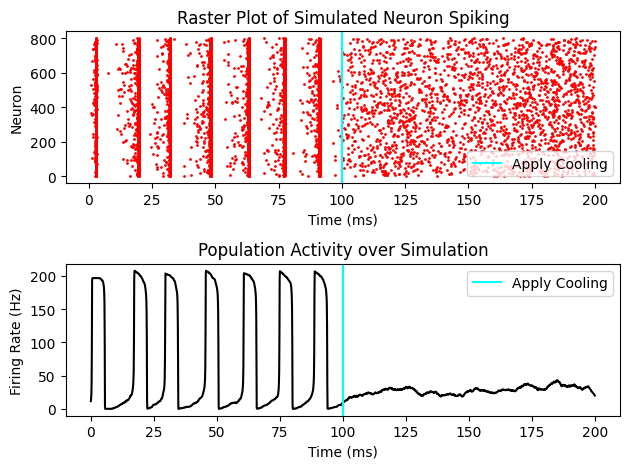

In [26]:
start_scope()

#set duration and cell count. Ratios for excitatory to inhibitory follow the frontal lobe ratio of 4:1
duration = 0.1 * second
N = 1000
Ne = int(0.8 * N)
Ni = N - Ne

# T1 is our reference temperature (body temp), T2 is the simulated temperature that we are applying
T1 = 37
T2 = 37  #Simulates body being at same temperature, this is changed later

#Standard Q10 coefficents. Q10 for tau is to scale tau in response to temperature changes, indicative of time constant changes
#Q10 for syn is to scale syn in response to temp changes, indicative of synaptic kinetics changing in response to temp
tQ10 = 2.5
sQ10 = 2.0

# tau constant for LiF model
tau = 10 * ms / (tQ10 ** ((T2 - T1) / 10))  # scaled by temp via Q10 manipulation

#voltage behavior that determines how LiF model spikes and resets itself
v_rest = -65 * mV
v_reset = -65 * mV
v_thresh = -50 * mV

#refractory period is dependent on temperature
refractory_period = 2 * ms / (tQ10 ** ((T2 - T1) / 10))

w_exc = 0.8 *  mV * (sQ10 ** ((T2 - T1) / 10))
w_inh = -0.4 * mV * (sQ10 ** ((T2 - T1) / 10))

# LiF Equation
# v-rest - v / tau is basic equation for LiF model
# sigma * xi * (1.0/sqrt(ms)) is an input for synaptic noise
# sigma is amplitude of noise
# xi is a bell curve distribution operater with mean 0 and stdev 1
eqs = '''
dv/dt = (v_rest - v) / tau + sigma * xi * (1.0 / sqrt(ms)): volt (unless refractory)
'''

#amplitude of noise
sigma = 3 * mV

#bunch excitatory neurons and inhibtiroy neurons
Exc_Neurons = NeuronGroup(Ne, eqs, threshold='v > v_thresh', reset='v = v_reset', refractory=refractory_period, method='euler')
Inh_Neurons = NeuronGroup(Ni, eqs, threshold='v > v_thresh', reset='v = v_reset', refractory=refractory_period, method='euler')

#set resting potential of neurons
Exc_Neurons.v = 'v_rest + rand() * 10 * mV'
Inh_Neurons.v = 'v_rest + rand() * 10 * mV'

#form synapses
S_ee = Synapses(Exc_Neurons, Exc_Neurons, on_pre='v_post += w_exc')
S_ei = Synapses(Exc_Neurons, Inh_Neurons, on_pre='v_post += w_exc')
S_ie = Synapses(Inh_Neurons, Exc_Neurons, on_pre='v_post += w_inh')
S_ii = Synapses(Inh_Neurons, Inh_Neurons, on_pre='v_post += w_inh')

#allow synaptic connections to be subject to probability of connetion
S_ee.connect(p=0.1)
S_ei.connect(p=0.1)
S_ie.connect(p=0.1)
S_ii.connect(p=0.1)

#set up monitors to make a not of when LiF neurons fire and reset (we only care about excitatory neurons here)
spike_monitor = SpikeMonitor(Exc_Neurons)

#population monitor to determine firing rate as a whole
pop_monitor = PopulationRateMonitor(Exc_Neurons)

#NORMAL RUN
run(duration)
#HOT RUN
# T1 is our reference temperature (body temp), T2 is the simulated temperature that we are applying
T1 = 37
T2 = 20  #Simulates body being at same temperature, this is changed later

#Standard Q10 coefficents. Q10 for tau is to scale tau in response to temperature changes, indicative of time constant changes
#Q10 for syn is to scale syn in response to temp changes, indicative of synaptic kinetics changing in response to temp
tQ10 = 2.5
sQ10 = 2.0

# tau constant for LiF model
tau = 10 * ms / (tQ10 ** ((T2 - T1) / 10))  # scaled by temp via Q10 manipulation

#voltage behavior that determines how LiF model spikes and resets itself
v_rest = -65 * mV
v_reset = -65 * mV
v_thresh = -50 * mV

#refractory period is dependent on temperature
refractory_period = 2 * ms / (tQ10 ** ((T2 - T1) / 10))

w_exc = 0.8 *  mV * (sQ10 ** ((T2 - T1) / 10))
w_inh = -0.4 * mV * (sQ10 ** ((T2 - T1) / 10))
run(duration)

# Plotting the results
# Use Raster Plot to Visualize Spiking during Simulation
fig, ax = plt.subplots(2)
ax[0].plot(spike_monitor.t/ms, spike_monitor.i, 'r.', markersize=2)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Neuron')
ax[0].set_title('Raster Plot of Simulated Neuron Spiking')
ax[0].axvline(x=100,label="Apply Cooling",color='cyan')
ax[0].legend()
# Look for firing rate across entire population and plot
ax[1].plot(pop_monitor.t/ms, pop_monitor.smooth_rate(window='flat', width=5*ms)/Hz, color='k')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Firing Rate (Hz)')
ax[1].set_title('Population Activity over Simulation')
ax[1].axvline(x=100,label="Apply Cooling",color='cyan')
ax[1].legend()
fig.tight_layout()
fig.show()